# Linear models for classification

Let us now look at linear models for classification. Such models are characterized by the fact that they attempt to separate the classes from each other using hyperplanes in the attribute space. 

## Linear regression for classification

The simplest way (having gone through the previous section) to build a linear model for classification into $K$ classes is to encode the target classes using vectors $\{0,1\}^K$ such that 1 is in the $i$-th position when the instance belongs to class $i$. Thus, for each class we have a vector 0 and 1 of length $N$ and $p$ attributes. It is not a problem to learn a linear model for regression that will try to predict 0 and 1 and hence membership in a given class. We train as many such models as there are classes, and when classifying, we each of them and choose as the predicted class the one whose model returned the largest value.

Actually, there is no need to compute multiple linear regressions, just one with multiple output values (multiple linear regression). The main difference is that the computation is faster, the predictions for single-valued classes are not affected. So if we write the target vectors in the matrix $Y$ row by row, we get the parameter estimates of all regressions as $$\hat{B} = (X^TX)^{-1}X^TY.$$ $B$ is a matrix $(p \times K)$, its individual columns correspond to the regression coefficients for a given target class. 

The main disadvantage of this approach is that some classes may be completely masked by other classes, i.e. no instances will be assigned to them during classification. Let's look at this in the following example.

Number of instances classified to each of the classes: [154   0 146]


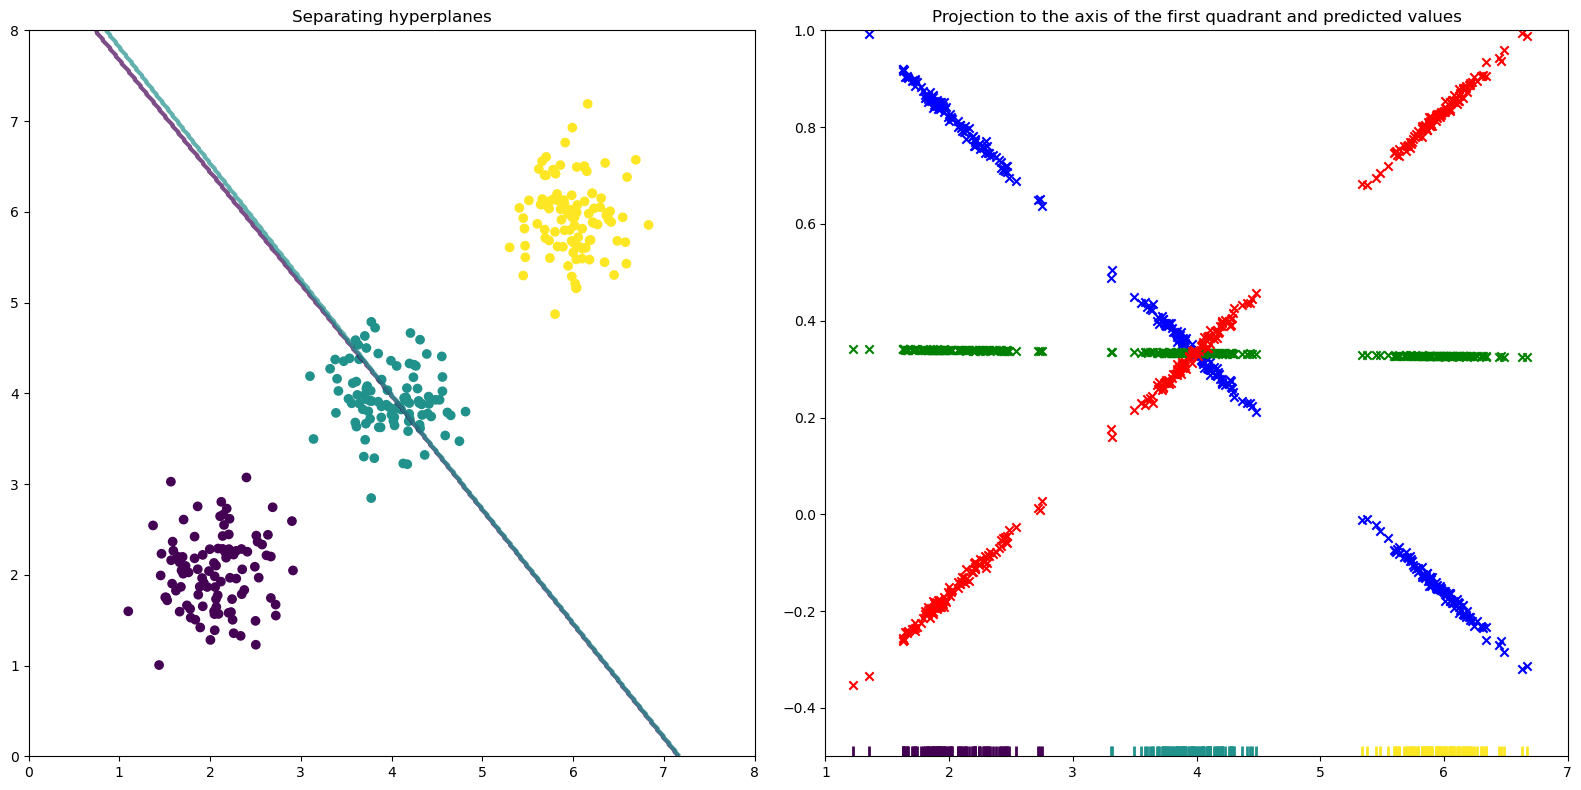

In [1]:
%matplotlib inline
from sklearn import datasets, preprocessing
import statsmodels.api as sm
from patsy.contrasts import Treatment
import numpy as np
import matplotlib.pyplot as plt

# generate the data
centers = [(2, 2), (4, 4), (6, 6)]
X, y = datasets.make_blobs(n_samples=300, n_features=2, cluster_std=0.4, centers=centers, shuffle=False, random_state=16)
X = np.hstack((np.ones(shape=(300, 1)), X))
# manual one-hot encoding
Y = np.eye(3)[y,:]
# this is manual implementation of linear regression
B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

# compute the predictions and number of instances predicted to each of the classes
pred = np.dot(X, B)
classes = np.argmax(pred, axis=1)
counts = np.bincount(classes)
print('Number of instances classified to each of the classes:', counts)

# plot the separating hyperplanes
XX, YY = np.meshgrid(np.linspace(0, 8, 500), np.linspace(0, 8, 500))
points = np.array([np.ones(500*500), XX.ravel(), YY.ravel()]).T
classes = np.argmax(np.dot(points, B), axis=1)
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.scatter(X[:, 1], X[:, 2], c=y)
ax.contour(XX, YY, classes.reshape(XX.shape), levels=[0,1,2], alpha=0.7, linewidths=[3])
ax.set_title('Separating hyperplanes')
ax.set_aspect(1.0)

# on the line with the slope of 1, the classes are easy to separate, let's plot a projection to this line
proj = (X[:, 1] + X[:, 2])/2
ax = plt.subplot(1,2,2)
ax.scatter(proj, np.zeros(300)-0.5, c=y, marker='|', s=200, linewidths=2)
ax.scatter(proj, pred[:, 0], c='blue', marker='x')
ax.scatter(proj, pred[:, 1], c='green', marker='x')
ax.scatter(proj, pred[:, 2], c='red', marker='x')
ax.set_ybound([-0.5, 1])
ax.set_xbound([1,7])
ax.set_title('Projection to the axis of the first quadrant and predicted values')

plt.tight_layout()
plt.show()

## Linear discriminant analysis (LDA)

The aim of classification is to decide into which class a sample belongs to. This can be done, for example, by calculating the probability that a given sample belongs to a class and selecting the most likely one. Suppose that we have a function $f_k$ that gives us the probability of a sample $x$ given that it belongs to class $k$, and $\pi_k$ are the a priori probabilities of belonging to class $k$. Then the probability of a sample $x$ belonging to class $k$ can be expressed as $$\mathrm{Pr}(G=k|X=x) = \frac{f_k(x)\pi_k}{\sum_{i=1}^Kf_i(x)\pi_i}.$$ 


This works in general, regardless of how the funtion $f_k$ is obtained. In case of LDA $$f_k(x) = \frac{1}{(2\pi)^{p/2}|\Sigma_k|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)\Sigma_k^{-1}(x-\mu_k)}, $$ where $\mu_k$ is the mean of the instances belonging to class $k$ and $\Sigma_k$ is their covariance matrix. Moreover, in LDA, the covariance matrix is assumed to be the same for all classes. But why is such a model called _linear_ discriminant analysis? Let's look at the boundary between the two classes. For that, it is useful to calculate the log likelihood ratio of the two classes. Where the likelihood ratio is 1, i.e. its logarithm is 0, then we have a boundary. $$\log\frac{\mathrm{Pr}(G=k|X=x)}{\mathrm{Pr}(G=l|X=x)} = \log\frac{f_k(x)}{f_l(x)} + \log\frac{\pi_k}{\pi_l} = \log\frac{\pi_k}{\pi_l}-\frac{1}{2}(\mu_k + \mu_l)\Sigma^{-1}(\mu_k-\mu_l)+x^T\Sigma^{-1}(\mu_k-\mu_l).$$ We can see that this boundary is a linear function of $x$ and hence the classes are separated by hyperplanes. This is due to the assumption on the same covariance matrix for all classes that ensures that all higher terms cancel when dividing. If we did not have this assumption, we would get quadratic discriminant analysis (QDA), the boundaries between classes would be quadratic functions. 

The question is where to get the values of $\pi_k$, $\Sigma$ and $\mu_k$, but that is easy, they can be unhandled directly from the data. 
- $\pi_k = N_k/N$
- $\mu_k = \sum_{g(x_i) = k}x_i/N_k$
- $\Sigma = \sum_{k=1}^K\sum_{g(x_i)=k}(x_i-\mu_k)(x_i-\mu_k)^T/(N-K)$

And that's it, we now have everything we need for LDA. If we were to use all of the $K$ matrices of $\Sigma_k$, instead of just one matrix of $\Sigma$, we would get QDA. Let's see what boundaries determined by linear regression, LDA, and QDA look like on simple data in 2D. One of the advantages of LDA is that it has no risk of masking classes, as was the case with the previous method.

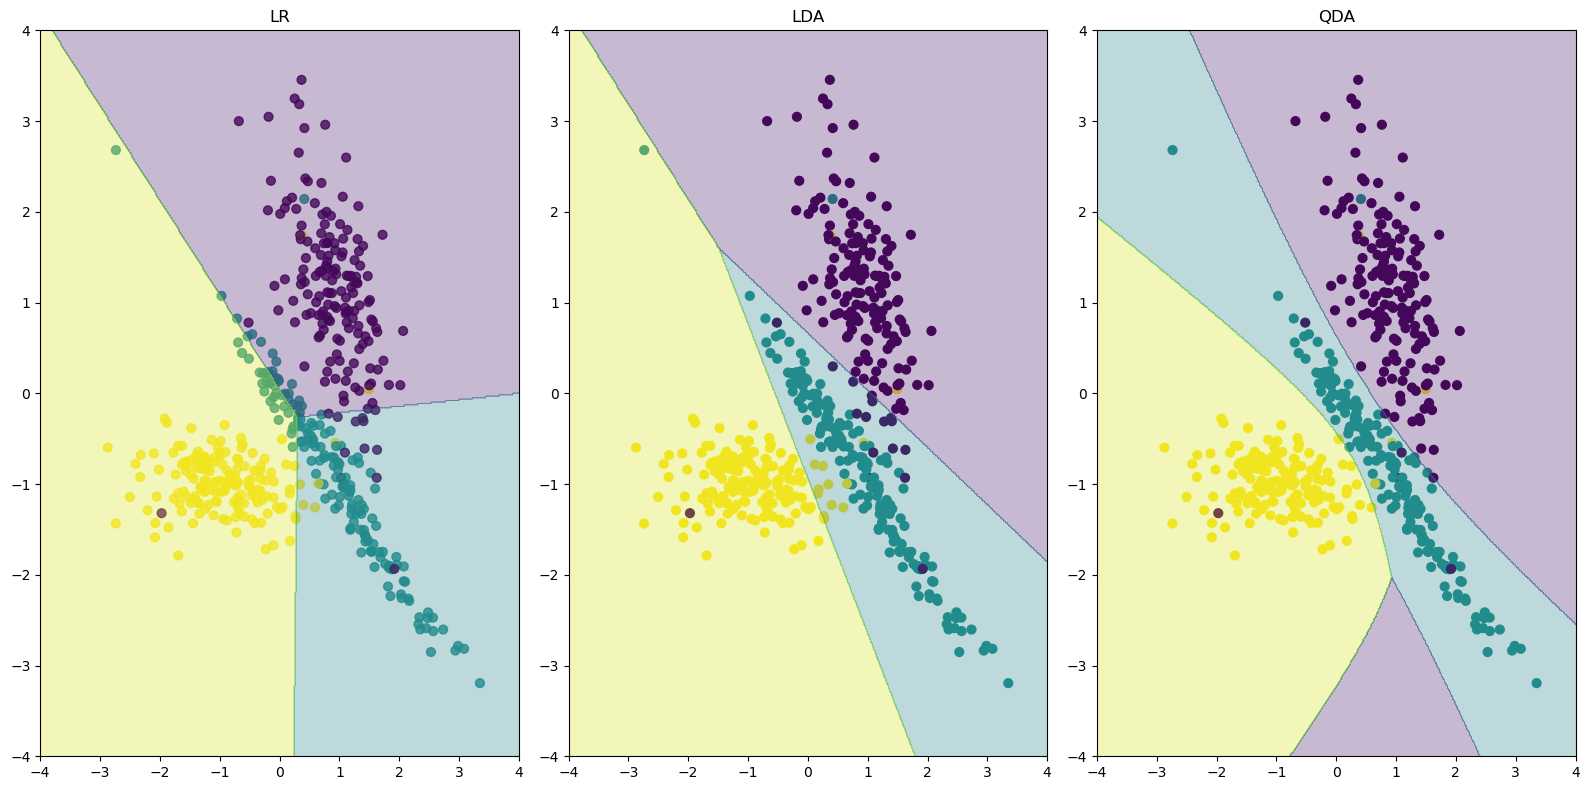

In [2]:
from sklearn import discriminant_analysis, linear_model

# create a simple classification dataset
X, y = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                                    random_state=1)

XX, YY = np.meshgrid(np.linspace(-4, 4, 500), np.linspace(-4, 4, 500))
points = np.array([XX.ravel(), YY.ravel()]).T

#compare the separating hyperplanes of LDA, QDA, and LR
clf_lda = discriminant_analysis.LinearDiscriminantAnalysis()
clf_lda.fit(X, y)
pred_lda = clf_lda.predict(points)

clf_qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
clf_qda.fit(X, y)
pred_qda = clf_qda.predict(points)

clf_lr = linear_model.LinearRegression()
clf_lr.fit(X, np.eye(3)[y,:])
pred_lr = np.argmax(clf_lr.predict(points), axis=1)

plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 3, 1)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
ax.contourf(XX, YY, pred_lr.reshape(XX.shape), alpha=0.3)
ax.set_title('LR')

ax = plt.subplot(1, 3, 2)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40)
ax.contourf(XX, YY, pred_lda.reshape(XX.shape), alpha=0.3)
ax.set_title('LDA')

ax = plt.subplot(1, 3, 3)
ax.scatter(X[:, 0], X[:, 1], c=y, s=40)
ax.contourf(XX, YY, pred_qda.reshape(XX.shape), alpha=0.3)
ax.set_title('QDA')

plt.tight_layout()
plt.show()

## Logistic regression

Logistic regression, despite its name, is also a classification method. It a lot in common with LDA, but its derivation and the method of estimating the parameters is completely different. For logistic regression, we want the logarithm of the probability ratios of two classes to be a linear function, so that
$$\eqalign{
\log\frac{\mathrm{Pr}(G=1|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{01}+\beta_1^Tx \cr
\log\frac{\mathrm{Pr}(G=2|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{02}+\beta_2^Tx \cr
\vdots \cr
\log\frac{\mathrm{Pr}(G=K-1|X=x)}{\mathrm{Pr}(G=K|X=x)} &=\beta_{0(K-1)}+\beta_{K-1}^Tx }$$

A simple adjustment of this gives the probabilities of the individual classes
$$\eqalign{
\mathrm{Pr}(G=k|X=x) &= \frac{e^{\beta_{0k} + \beta_k^Tx}}{1+\sum_{l=1}^{K-1}e^{\beta_{0l} + \beta_l^Tx}} \mathrm{~pro~} k = 1, \dots k-1 \cr
\mathrm{Pr}(G=K|X=x) &= \frac{1}{1+\sum_{l=1}^{K-1}e^{\beta_{0l^Tx}} \mathrm{~else}\cr
}$$

The parameters of the model are found using the maxium likelihood method, i.e. maximization of the logarithmic likelihood $$l(\theta)=\sum_{i=1}^N\log\mathrm{Pr}(G=g(x_i X)|x_i, \theta),$$ where $g(x_i)$ is the correct class for $x_i$.

Interestingly, as with LDA, logistic regression has linear boundaries separating the individual classes. It would seem that the two models are the same. In fact, logistic regression is a bit more general, as it does not have the assumption of the same covariances of the individual classes. In practice, however, both methods often give similar results.

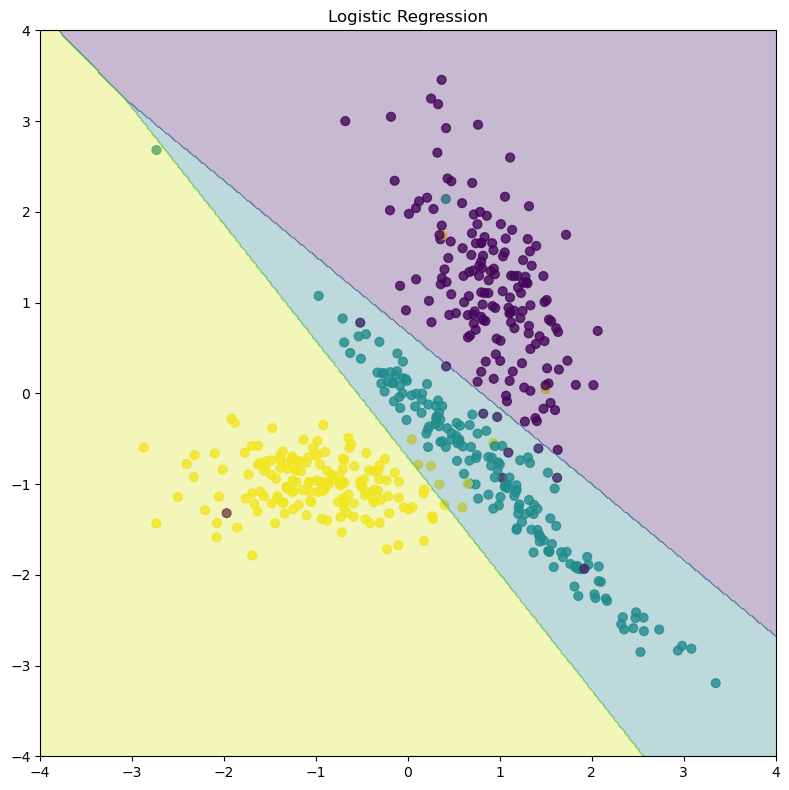

In [3]:
clf_logR = linear_model.LogisticRegression()
clf_logR.fit(X, y)
pred_logR = clf_logR.predict(points)

#plot separating hyperplane for logistic regression
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
plt.contourf(XX, YY, pred_logR.reshape(XX.shape), alpha=0.3)
plt.title('Logistic Regression')
plt.tight_layout()
plt.show()

## Perceptron

The last two models we will discuss model the separating hyperplane directly. So we look for the vector $\beta$, such that the dividing superplane is given by $x^T\beta + \beta_0 = 0$. The target classes in this case are encoded as 1 and -1 and the perceptron minimizes $$D(\beta, \beta_0) = - \sum_{i \in M}y_i(x_i^T\beta + \beta_0),$$ where $M$ is a set of patterns that are misclassified. Perceptron minimizes this value by using a gradient algorithm, taking the derivative with respect to $\beta$ and $\beta_0$ we get a one step rule $\beta_0 \leftarrow \beta_0 + \rho y_i, \beta \leftarrow \beta + \rho y_ix_i$ (the derivative actually contains the sum over the set $M$, so the perceptron makes a stochastic gradient descend because it changes the estimate after each pattern is submitted and not batch-wise). We can prove that for linearly separable sets the perceptron algorithm always finds the separating superplane.

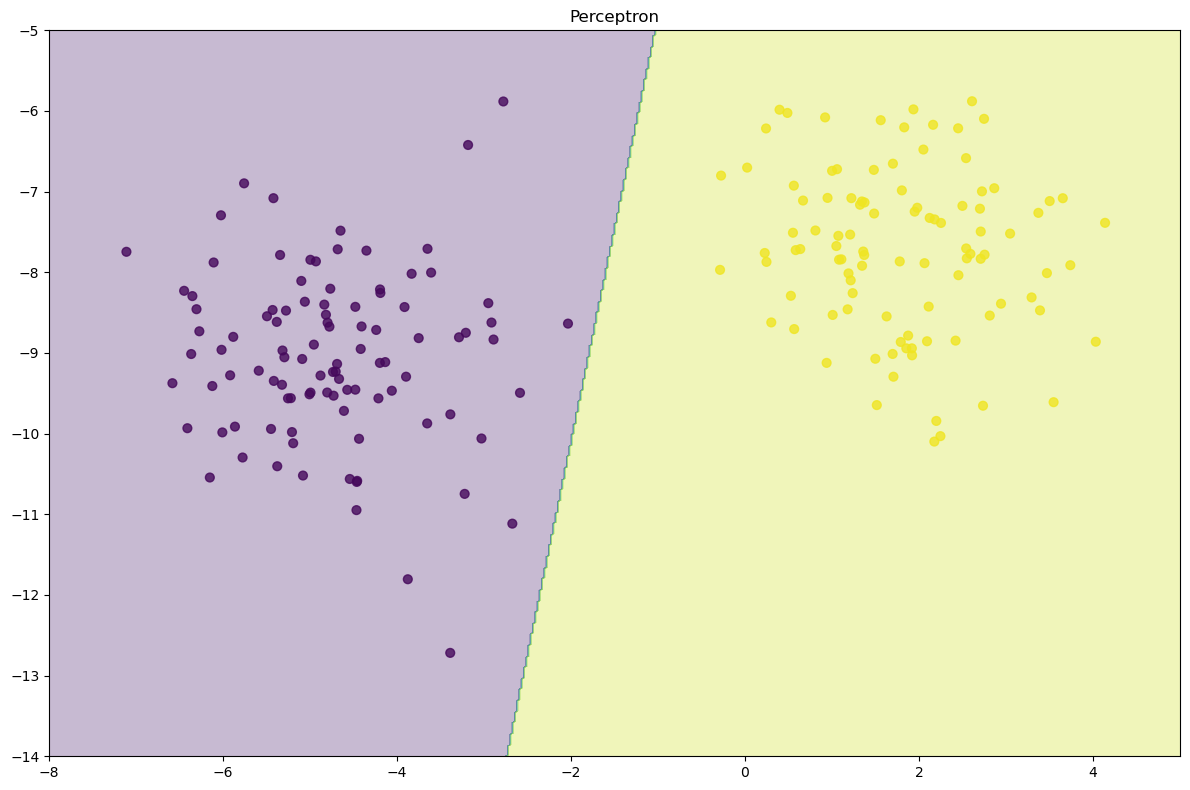

In [4]:
#create linearly separable data (depends on the seed)

X, y = datasets.make_blobs(n_features=2, n_samples=200, centers=2, random_state=68)

# plot the perceptron separating hyperplane
XX, YY = np.meshgrid(np.linspace(-8, 5, 500), np.linspace(-14, -5, 500))
points = np.array([XX.ravel(), YY.ravel()]).T

clf_perc = linear_model.Perceptron(max_iter=100)
clf_perc.fit(X, y)
pred_perc = clf_perc.predict(points)

plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, alpha=0.8)
plt.contourf(XX, YY, pred_perc.reshape(XX.shape), alpha=0.3)
plt.title('Perceptron')
plt.tight_layout()
plt.show()

## Maximum margin separating hyperplane

The hyperplane found by the perceptron is not uniquely determined, the algorithm can converge to any of the hyperplanes that separate the data, the specific hyperplane found depends on the initialization of the algorithm. This problem is solved by the maximum margin separating hyperplane (MMSH). It additionally looks for the hyperplane that is as far away from both sets as possible. So it tries to solve the problem $$\max_{\beta, \beta_0, ||\beta||=1} M$$ under the conditions $$y_i(x_i^T\beta+\beta_0) \geq M$$ for each $i$. This can be written as $$\min_{\beta, \beta_0}\frac{1}{2}|\beta||^2$$ under the conditions $$y_i(x_i^T\beta+\beta_0) \geq 1.$$ This problem is then solved using quadratic programming methods.

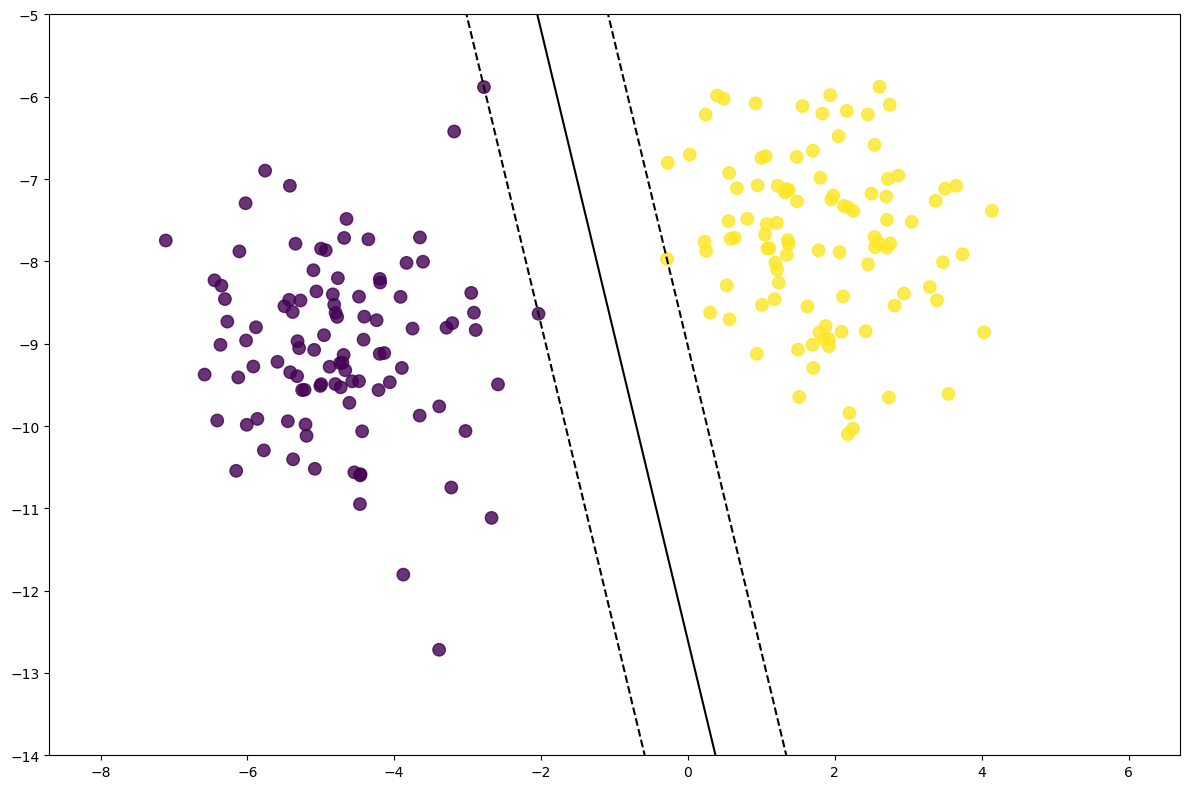

In [5]:
from sklearn import svm

# find the maximum margin separating hyperplane
clf_mmc = svm.SVC(kernel='linear')
clf_mmc.fit(X, y)

# plot margin, support vectors and separating hyper-plane (taken from scikit-learn docs)
w = clf_mmc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-8, 6)
yy = a * xx - (clf_mmc.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf_mmc.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf_mmc.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(12,8))
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf_mmc.support_vectors_[:, 0], clf_mmc.support_vectors_[:, 1], s=200, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=y, s=80, alpha=0.8)
plt.gca().set_ybound([-14,-5])

plt.tight_layout()
plt.show()